In [3]:
! pip install pillow

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (14.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

#OCR
In order to work with OCR the first step os to get the picture. One of the library which can be used is “Pillow”. Here is some useful funcetions from the mentioned library :


In [5]:
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract

In [6]:
def display(im_data):

    dpi = 80
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()
def display_grey(im_data ):
  plt.figure(figsize=(30, 15))

  for img in range(len(im_data)) :

    plt.subplot(   1 , len(im_data) ,img+1)
    plt.imshow(im_data[img] , cmap='gray')
    plt.axis('off')
  plt.show()



## Preprocessing
It can be done using Open CV. it has several steps that will be discussing in the follwing boxes.
### Inverting
As you see in the code belo the color of the picture has been inverted.

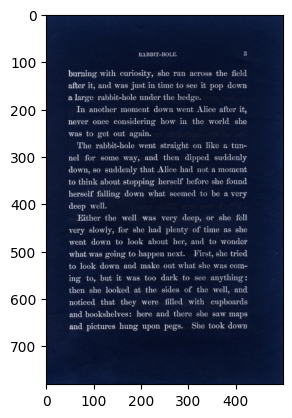

In [ ]:
import cv2
pic = cv2.imread("/content/Alice-In-Wonderland-Book-Page-3-Old-Design-Shop-500x781.jpg")
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
inverted_pic = cv2.bitwise_not(pic)
plt.imshow(inverted_pic)

## Rescaling

## Binerization
Firstly the picture should be converted to garyscale .
one of the approaches for binerization is using threshholding. its documention can be found in the link below:
https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

In [7]:
import cv2
pic = cv2.imread("/content/OCR.jpg")
gray_pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)


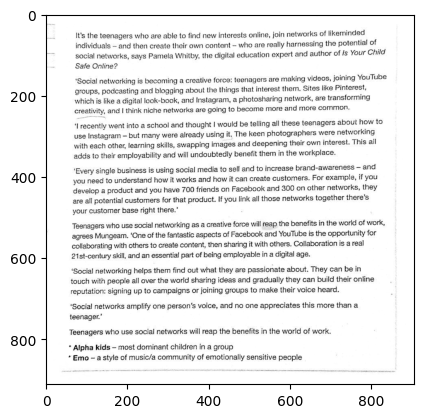

In [34]:
plt.imshow(gray_pic , cmap='gray')

Here we test som of binerization.


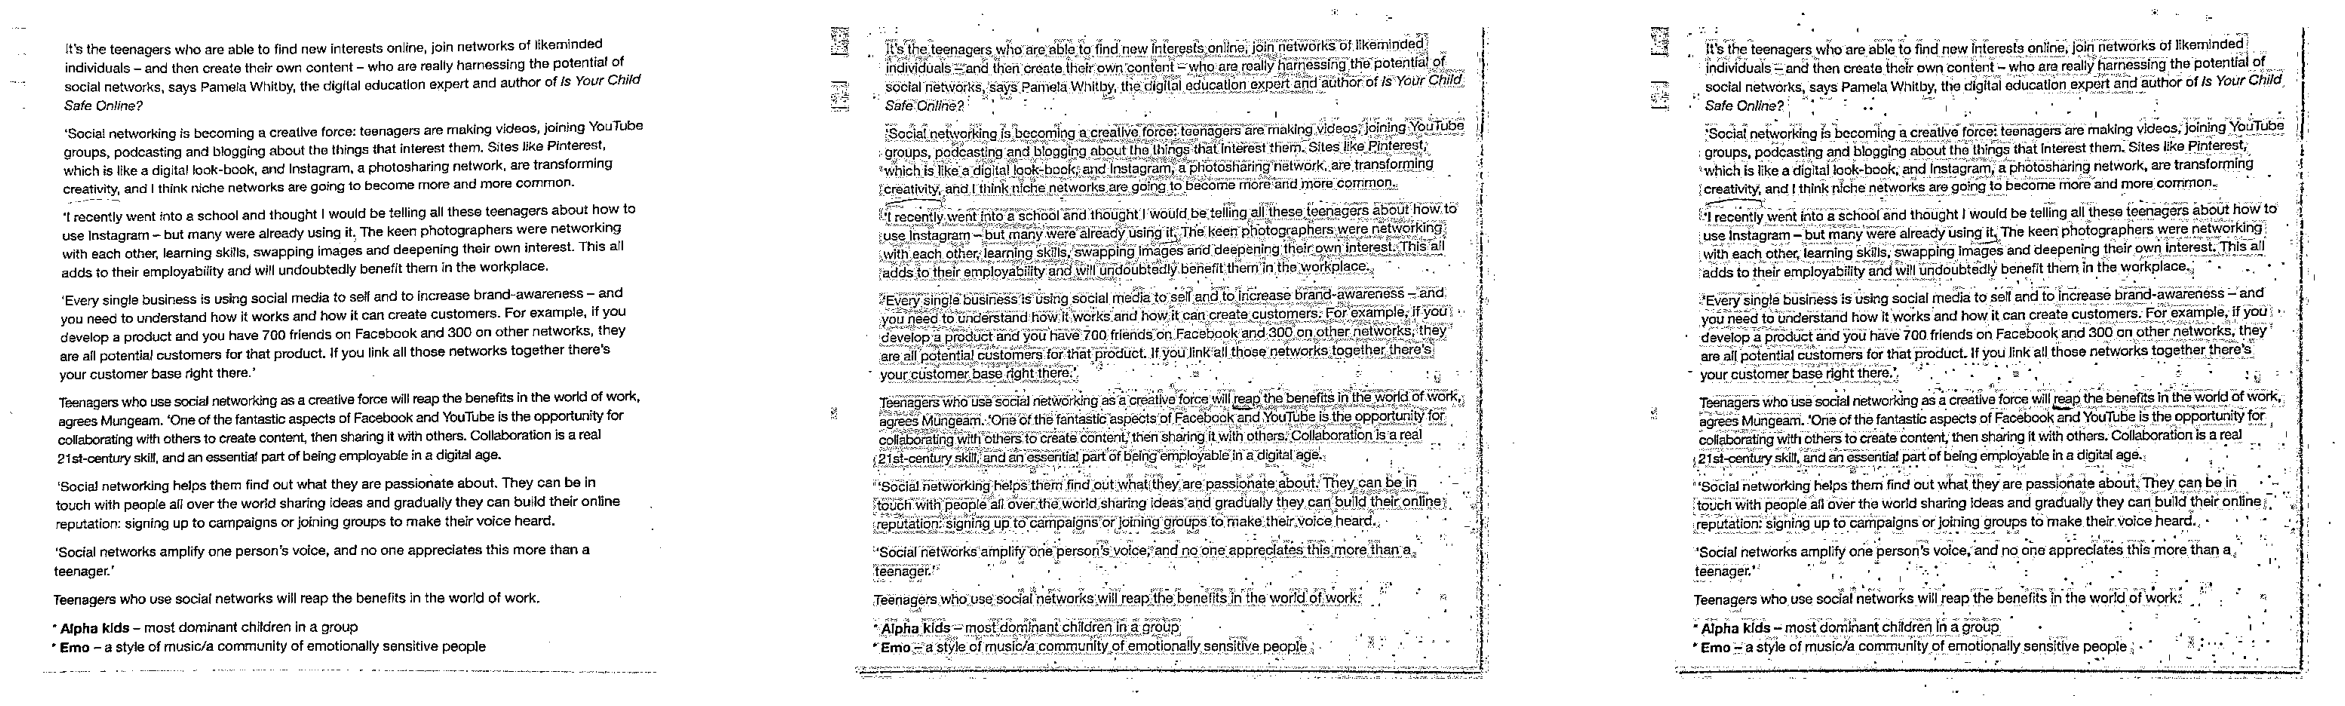

In [11]:
images= []
ret1 , tresh1 = cv2.threshold(gray_pic ,180 , 255 , cv2.THRESH_BINARY)
tresh2 = cv2.adaptiveThreshold(gray_pic , 255 , cv2.ADAPTIVE_THRESH_GAUSSIAN_C , cv2.THRESH_BINARY , 11 , 2)
tresh3 = cv2.adaptiveThreshold(gray_pic , 255 , cv2.ADAPTIVE_THRESH_MEAN_C , cv2.THRESH_BINARY , 11 , 2)

images.append(tresh1)
images.append(tresh2)
images.append(tresh3)

display_grey(images )

## Remove the noises
The first point is erosion and dilation : \\
### Erosion:
 Erosion removes pixels on object boundaries. A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel are 1, otherwise it is eroded (made to zero).

This operation is useful for removing small white noises, detach two connected objects, etc.

###  Dilation:
 Dilation adds pixels to the boundaries of objects in an image. A pixel element in the original image is ‘1’ if at least one pixel under the kernel is ‘1’.

This operation is useful for joining broken parts of an object, increasing the size of the object, etc.

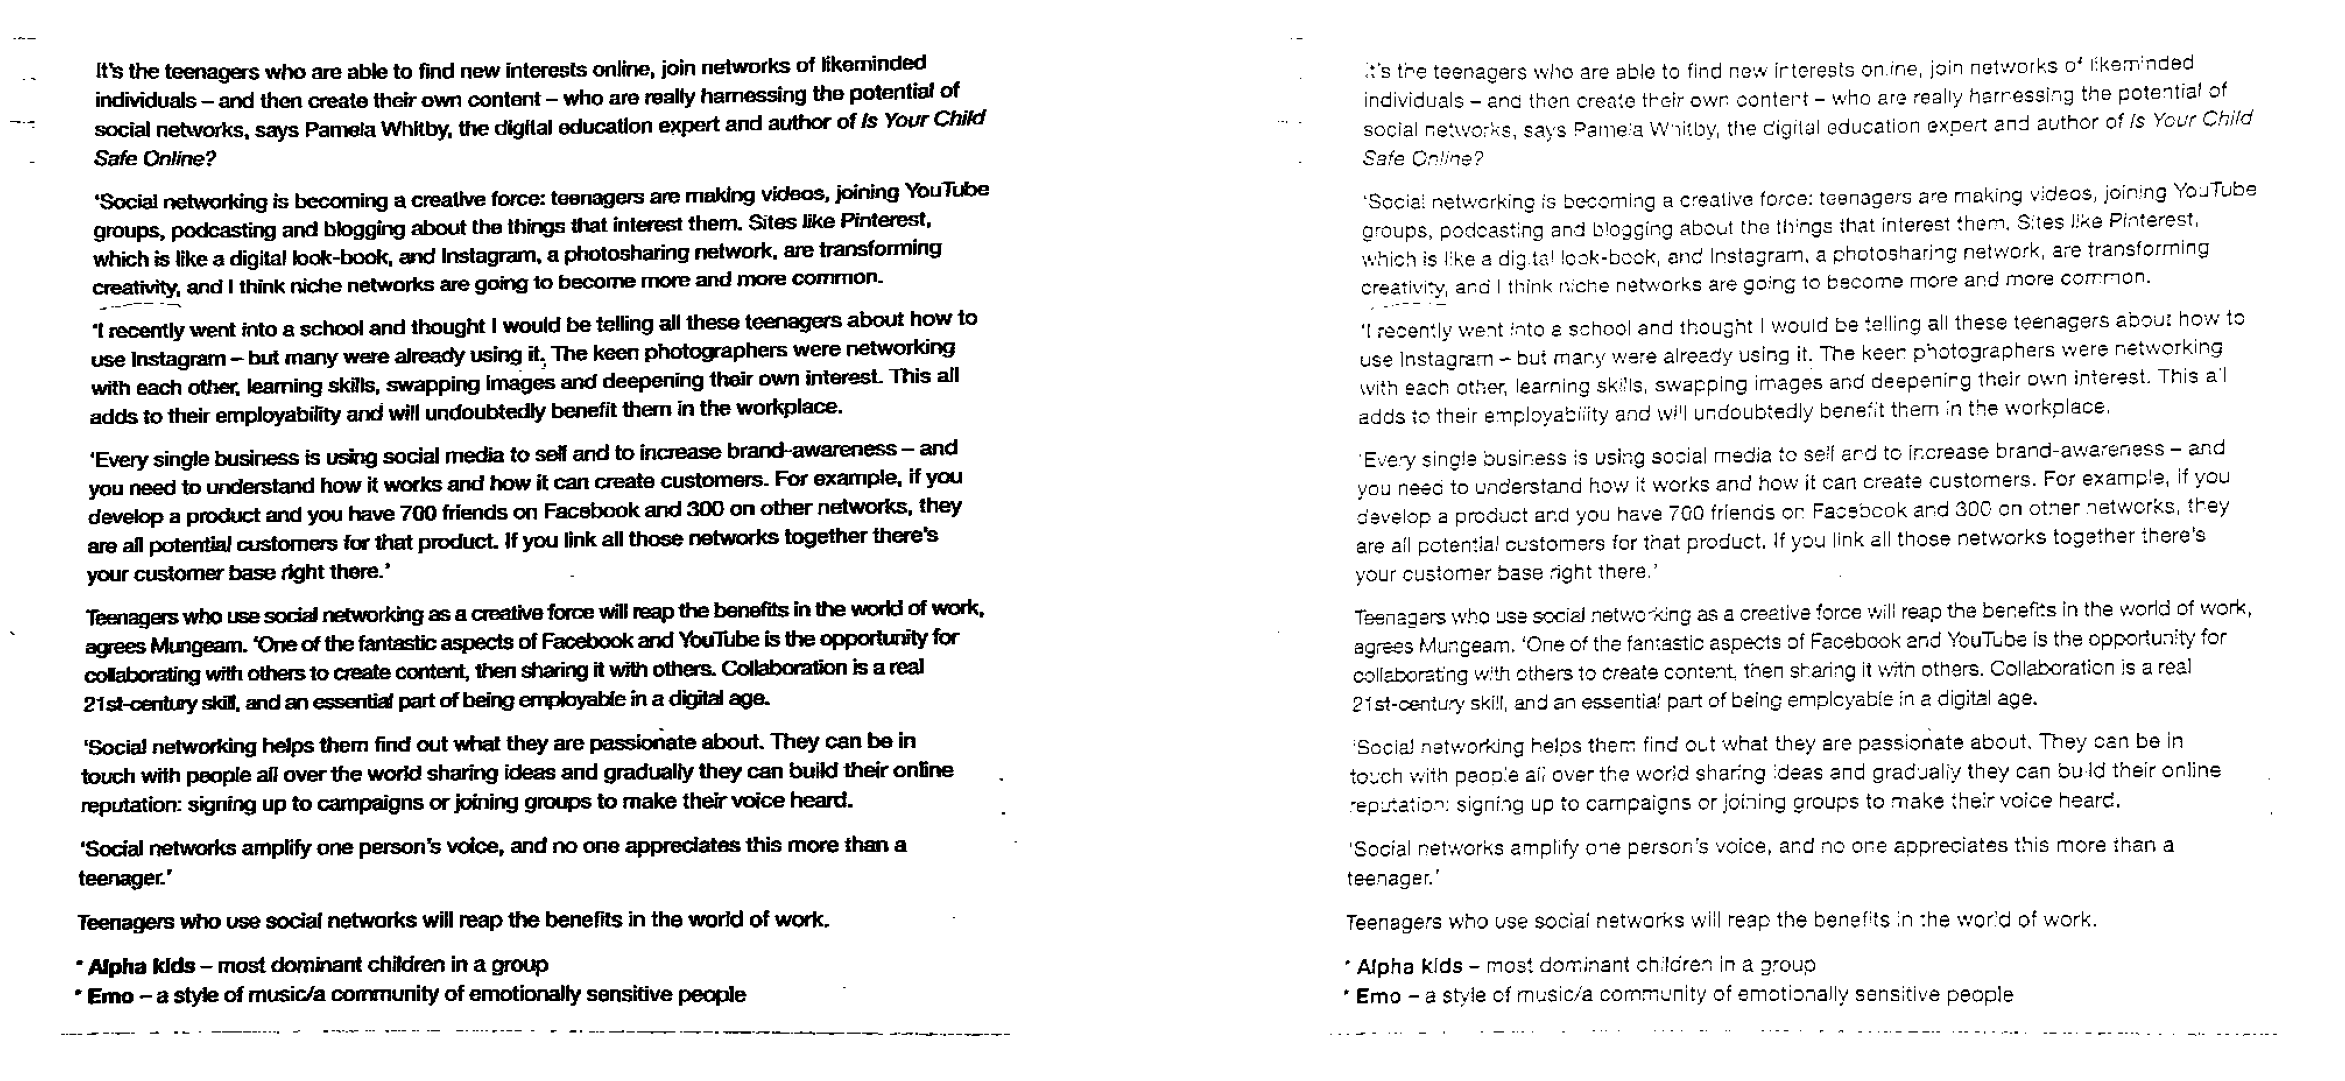

In [15]:
import numpy as np
kernel = np.ones((1,2),np.uint8)

pic1 = cv2.erode(tresh1 , kernel , iterations = 1)
pic2 = cv2.dilate(tresh1 , kernel , iterations = 1)

images = []
images.append(pic1)
images.append(pic2)
display_grey(images)


It seems not gut to implement the gussian blur.

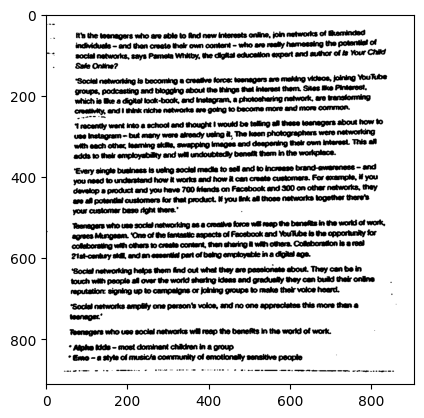

In [19]:
pic3 = cv2.GaussianBlur(pic1 , (3,3) , 0)
ren , pic3 = cv2.threshold(pic3 , 200 , 255 , cv2.THRESH_BINARY)
plt.imshow(pic3 , cmap='gray')

In [20]:
# using fft inorder to reduce the noise
import numpy as np
import cv2

def fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    return fshift

def coefficient_adjustment(fft_image, coefficient):
    height, width = fft_image.shape
    fft_image[0:int(height*coefficient), 0:width] = 0
    fft_image[:, -int(width*coefficient):] = 0
    fft_image[-int(height*coefficient):, :] = 0
    fft_image[:, 0:int(width*coefficient)] = 0
    return fft_image

def inverse_fourier_transform(fn, coefficient):
    magnitude = np.abs(fn)
    magnitude = coefficient_adjustment(magnitude, coefficient)
    phase = np.angle(fn)

    real = np.cos(phase) * magnitude
    imag = np.sin(phase) * magnitude
    fft = real + (1j * imag)
    image = np.fft.ifft2(np.fft.ifftshift(fft))
    image = np.real(image)
    image = image.clip(min=0, max=255).astype('uint8')
    return image

def reduce_noise(img, coefficient):
    return inverse_fourier_transform(fft(img), coefficient)



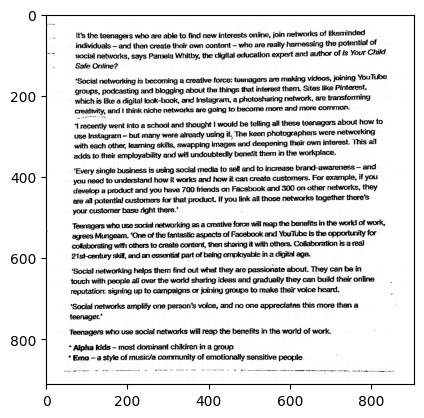

In [26]:
denoised = reduce_noise(pic1 , 0.01)
plt.imshow(denoised , cmap='gray')

In [37]:
def remove_borders(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntSorted = sorted(contours, key=lambda x: cv2.contourArea(x))
    cnt = cntSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return crop

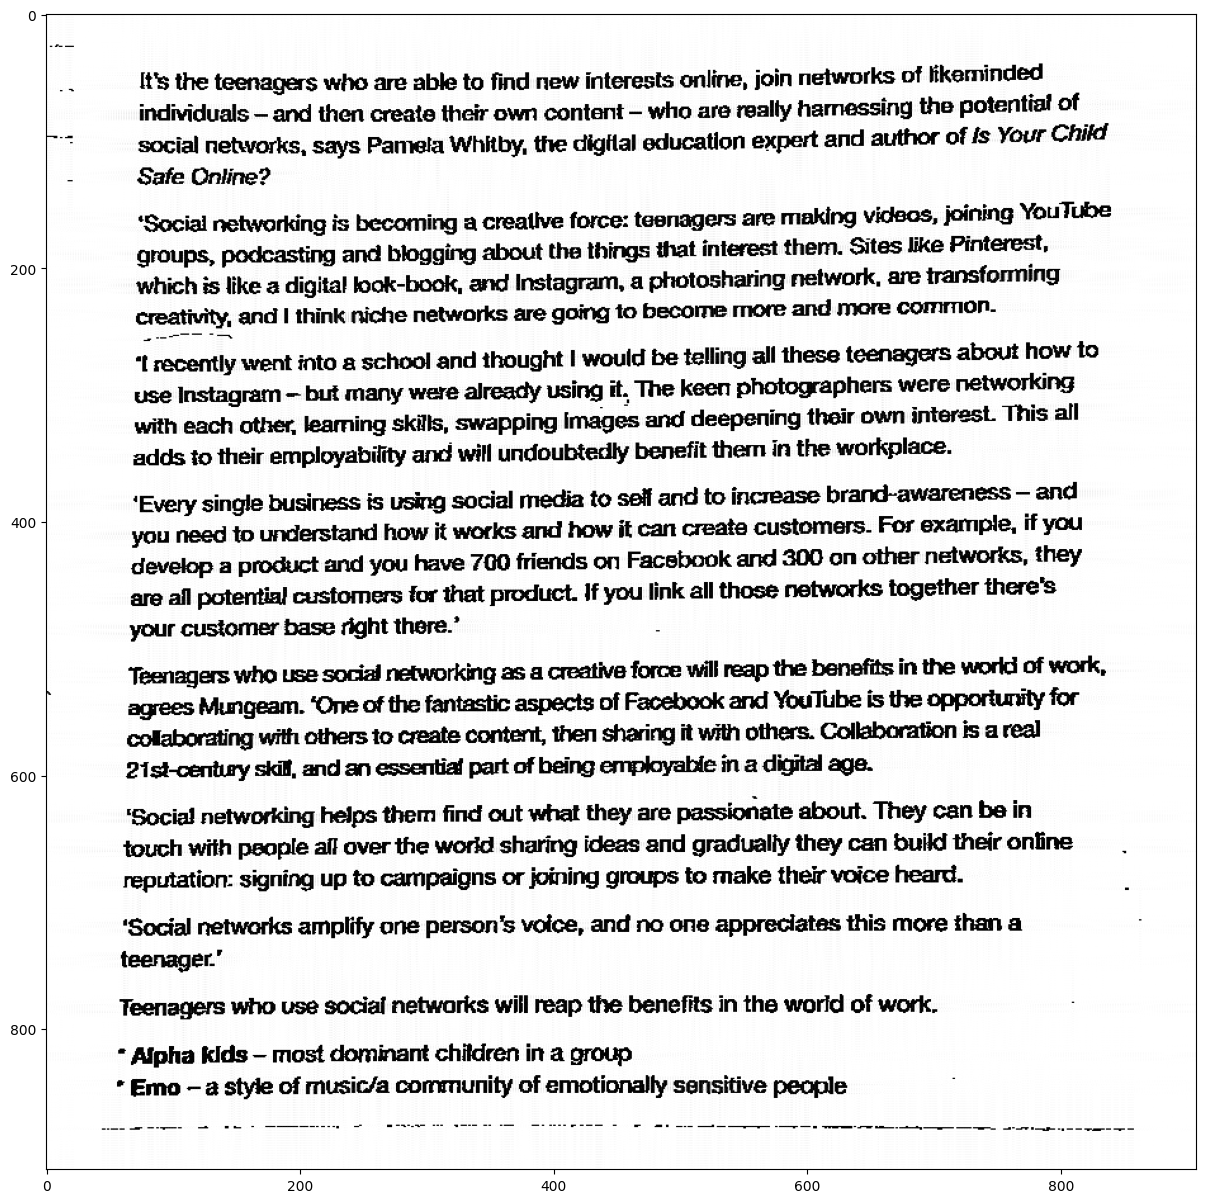

In [38]:
pic4 = remove_borders(denoised)
plt.figure(figsize=(30, 15))
plt.imshow(pic4 , cmap='gray')

## Deskew a text image
This function has been used from :https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df

In [29]:
# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    # gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

  # Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

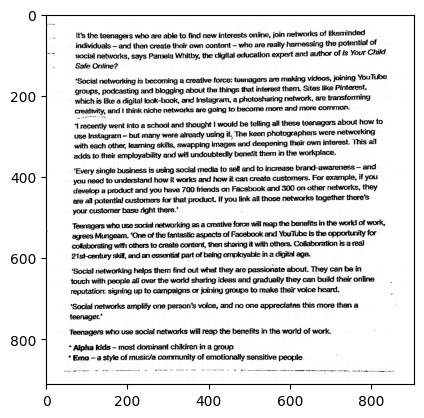

In [30]:
pic5 = deskew(pic4)
plt.imshow(pic5 , cmap='gray')

In [123]:
result = pytesseract.image_to_string(pic5)

In [124]:
print(result)

It's the teenagers who are able to find new interests online, join networks of likeminded
individuals — and then create their own content — who are really hamessing the potential of
social networks, says Pamela Whitby, the digital education expert and author of is Your Child

Safe Online?
‘Social networking is becoming a creative force: teenagers are making videos, joining YouTube

groups, podcasting and blogging about the things that interest them. Sites like Pinterest,
which is like a digital look-book, and Instagram, a photosharing network, are transforming
creativity, and I think niche networks are going to become more and more common.

“t recently went into a school and thought | would be telling all these teenagers about how to
use Instagram — but many were already using it, The keen photographers were networking
with each other, leaming skills, swapping images and deepening their own interest. This all
adds to their employability and will undoubtedly benefit them in the workplac

In [132]:
results = []
item = result.split('\n')
for word in item:
  results.append(word)

In [149]:
words = []
for item in results:
  new_item = item.split(' ')
  for word in new_item:
    word = word.replace('.' , '').replace(',','').replace(':','').replace(';','').replace('?','')
    if len(word) > 1 and (ord(word[0]) >= 97 or ord(word[0]) <= 123 or ord(word[0]) >= 65 or ord(word[0]) <= 91):
      words.append(word)

In [151]:
for word in words:
  print(word)

It's
the
teenagers
who
are
able
to
find
new
interests
online
join
networks
of
likeminded
individuals
and
then
create
their
own
content
who
are
really
hamessing
the
potential
of
social
networks
says
Pamela
Whitby
the
digital
education
expert
and
author
of
is
Your
Child
Safe
Online
‘Social
networking
is
becoming
creative
force
teenagers
are
making
videos
joining
YouTube
groups
podcasting
and
blogging
about
the
things
that
interest
them
Sites
like
Pinterest
which
is
like
digital
look-book
and
Instagram
photosharing
network
are
transforming
creativity
and
think
niche
networks
are
going
to
become
more
and
more
common
“t
recently
went
into
school
and
thought
would
be
telling
all
these
teenagers
about
how
to
use
Instagram
but
many
were
already
using
it
The
keen
photographers
were
networking
with
each
other
leaming
skills
swapping
images
and
deepening
their
own
interest
This
all
adds
to
their
employability
and
will
undoubtedly
benefit
them
in
the
workplace
‘Every
single
business
is
using
socia

In [165]:
unique_words = list(set(words))

In [166]:
print(unique_words)

['leaming', 'This', 'what', 'customer', 'how', 'find', 'Pinterest', 'networking', 'up', '21si-century', 'you', 'videos', "there's", 'there’', '‘Every', 'groups', 'into', 'if', 'others', 'For', 'new', 'creative', 'amplify', 'dominant', 'author', 'They', 'photosharing', 'then', 'it', 'photographers', 'really', '‘Social', 'community', 'emotionally', 'individuals', 'be', 'employability', 'interest', 'employable', '‘Teenagers', 'and', 'aspects', 'brand-awareness', 'worid', 'common', 'many', 'already', 'deepening', 'joining', 'Whitby', 'force', 'network', 'ail', 'base', 'hamessing', 'together', 'skills', 'Alpha', 'sharing', 'like', 'Teenagers', 'niche', 'likeminded', 'undoubtedly', 'images', 'Child', 'think', 'reap', 'which', 'helps', 'thought', 'with', 'expert', 'them', 'heard', 'becoming', 'things', 'touch', 'using', 'this', 'the', 'than', 'teenager”', 'gradually', 'is', 'social', 'example', 'those', 'understand', '‘One', 'being', 'agrees', 'age', 'Collaboration', 'can', 'other', 'works', 